<a href="https://colab.research.google.com/github/Bhargav-Hazarika/UDA-with-NST/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Base paths
GDRIVE_BASE = "/content/drive/MyDrive/NST Dataset/filter_preproc"

In [14]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from tqdm import tqdm

In [4]:
CONTENT_MANIFEST = GDRIVE_BASE + "/manifests/manifest.csv"
STYLIZED_MANIFEST = GDRIVE_BASE + "/manifests/stylized_manifest.csv"

content_df  = pd.read_csv(CONTENT_MANIFEST)
stylized_df = pd.read_csv(STYLIZED_MANIFEST)

In [5]:
class StylizedPairDataset(Dataset):
    def __init__(self, stylized_csv, transform=None):
        self.df = pd.read_csv(stylized_csv)

        self.transform = transform or transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        content_img = Image.open(row["content_path"]).convert("RGB")
        stylized_img = Image.open(row["stylized_path"]).convert("RGB")

        return (
            self.transform(content_img),
            self.transform(stylized_img)
        )


In [6]:
dataset = StylizedPairDataset(
    stylized_csv=STYLIZED_MANIFEST,
    transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(256),
      transforms.ToTensor()
    ])

)

loader = DataLoader(
    dataset,
    batch_size=16,        # tune based on GPU
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


### Sanity Check

In [7]:
c, s = next(iter(loader))
print(c.shape, s.shape)

torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


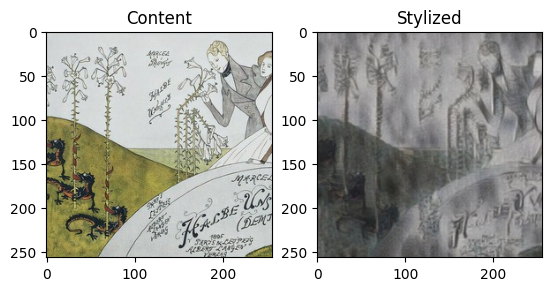

In [8]:
plt.subplot(1,2,1)
plt.imshow(c[0].permute(1,2,0))
plt.title("Content")

plt.subplot(1,2,2)
plt.imshow(s[0].permute(1,2,0))
plt.title("Stylized")
plt.show()

### MODEL BUILDING & TRAINING

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        base = resnet18(weights="IMAGENET1K_V1")
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # remove FC

    def forward(self, x):
        x = self.backbone(x)        # (B, 512, 1, 1)
        x = x.flatten(1)            # (B, 512)
        return x


In [11]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=512, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(inplace=True),
            nn.Linear(in_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [12]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.2):
        super().__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        B = z1.size(0)

        z = torch.cat([z1, z2], dim=0)        # (2B, D)
        z = F.normalize(z, dim=1)

        sim = torch.matmul(z, z.T)            # (2B, 2B)
        sim /= self.temperature

        mask = torch.eye(2 * B, device=z.device).bool()
        sim.masked_fill_(mask, -9e15)

        pos = torch.sum(z1 * z2, dim=1) / self.temperature
        pos = torch.cat([pos, pos], dim=0)

        loss = -pos + torch.logsumexp(sim, dim=1)
        return loss.mean()


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

encoder = Encoder().to(device)
projector = ProjectionHead().to(device)

criterion = NTXentLoss(temperature=0.2)

optimizer = torch.optim.AdamW(
    list(encoder.parameters()) + list(projector.parameters()),
    lr=3e-4
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 99.5MB/s]


In [15]:
def train_one_epoch(loader, encoder, projector, optimizer, criterion):
    encoder.train()
    projector.train()

    total_loss = 0

    for content, stylized in tqdm(loader):
        content  = content.to(device)
        stylized = stylized.to(device)

        h1 = encoder(content)
        h2 = encoder(stylized)

        z1 = projector(h1)
        z2 = projector(h2)

        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)

        loss = criterion(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [16]:
loss = train_one_epoch(loader, encoder, projector, optimizer, criterion)
print(f"Epoch 1 loss: {loss:.4f}")

  2%|▏         | 81/4125 [12:14<10:11:31,  9.07s/it]


KeyboardInterrupt: 